<a href="https://colab.research.google.com/github/brianellis1997/Sarcasm_Detection/blob/Lindsey/DS_440_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection using NLP Techniques
### Team 2: Brian Ellis, Lindsey Rich, Elena Kern

## Load Libraries and Dataset

In [1]:
import pandas as pd
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#test comment

In [2]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
!git clone https://github.com/brianellis1997/Sarcasm_Detection.git

Cloning into 'Sarcasm_Detection'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 92 (delta 46), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (92/92), 2.39 MiB | 7.73 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_bal = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/train-balanced-sarcasm.csv')   # Make sure path is correct in your google drive
train_bal.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [7]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [8]:
train_bal['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

We can see our dataset is balanced.

In [9]:
train_bal[:20]['comment']

0                                            NC and NH.
1     You do know west teams play against west teams...
2     They were underdogs earlier today, but since G...
3     This meme isn't funny none of the "new york ni...
4                       I could use one of those tools.
5     I don't pay attention to her, but as long as s...
6         Trick or treating in general is just weird...
7                       Blade Mastery+Masamune or GTFO!
8     You don't have to, you have a good build, buy ...
9                     I would love to see him at lolla.
10    I think a significant amount would be against ...
11                       Damn I was hoping God was real
12                                 They have an agenda.
13                                          Great idea!
14    Ayy bb wassup, it makes a bit more sense in co...
15                                        what the fuck
16                                               noted.
17    because it's what really bothers him... an

In [10]:
# Remove null rows
train_bal = train_bal[-train_bal['comment'].isnull()]
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


Now we're going to split our data into train and test sets using an 80/20 split

In [11]:
df_shuffled = train_bal.sample(frac=1, random_state=22)  # Shuffle data

# Split into train and test (80% train, 20% test)
train_bal, test_bal = train_test_split(df_shuffled, test_size=0.2, random_state=22)

print(train_bal.shape)
print(test_bal.shape)

(808618, 10)
(202155, 10)


In [12]:
train_bal['label'].value_counts(normalize=True)

1    0.500074
0    0.499926
Name: label, dtype: float64

In [13]:
test_bal['label'].value_counts(normalize=True)

0    0.500388
1    0.499612
Name: label, dtype: float64

## EDA

In [14]:
# Separating sarcastic vs non sarcastic comments
sarcastic_com = train_bal[train_bal['label'] == 1]
non_sarcastic_com = train_bal[train_bal['label'] == 0]

In [15]:
# # WordCloud for sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [16]:
# # WordCloud for non-sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# Visualizing Sarcastic Comments by Subreddit

In [17]:
subreddit_count = sarcastic_com['subreddit'].value_counts()

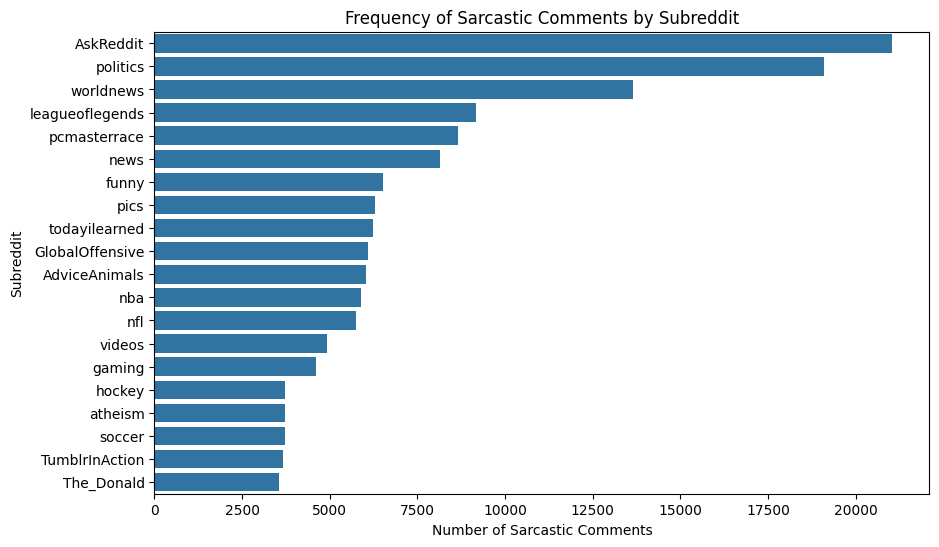

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
top = subreddit_count.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top.values, y=top.index)
plt.xlabel('Number of Sarcastic Comments')
plt.ylabel('Subreddit')
plt.title('Frequency of Sarcastic Comments by Subreddit')
plt.show()


In [19]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

import spacy # for a lemmatization example

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
comments = train_bal['comment']

In [21]:
comments.info()

<class 'pandas.core.series.Series'>
Int64Index: 808618 entries, 522142 to 213871
Series name: comment
Non-Null Count   Dtype 
--------------   ----- 
808618 non-null  object
dtypes: object(1)
memory usage: 12.3+ MB


In [22]:
comments.dropna(inplace=True)
comments.info()

<class 'pandas.core.series.Series'>
Int64Index: 808618 entries, 522142 to 213871
Series name: comment
Non-Null Count   Dtype 
--------------   ----- 
808618 non-null  object
dtypes: object(1)
memory usage: 12.3+ MB


In [23]:
!pip install dask[delayed]

In [24]:
import dask.dataframe as dd
from dask import delayed

In [25]:
comment_test = comments.head(10000)

#Create large function that does this text preprocessing so that it can be used with X_train, also figure out how to split and keep track of data


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
def preprocess(text):
  tokenized_comments = batch_tokenize(text.tolist())
  phrases = Phrases(tokenized_comments)
  bigram = Phraser(phrases)
  bigram_comments = [bigram[comment] for comment in tokenized_comments]
  tokenizer = Tokenizer(lower=False)
  tokenizer.fit_on_texts(bigram_comments)
  word_index = tokenizer.word_index
  word_size = len(word_index) + 1

  # uses tokenizer object with the created word index to make each comment a list of integers corresponding to their index
  sequences = tokenizer.texts_to_sequences(bigram_comments)


  return word_index, word_size, sequences



In [27]:
#  Replace this?
def batch_tokenize(texts, batch_size=50000):
    tokenized_texts = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokenized_batch = [word_tokenize(text) for text in batch]
        tokenized_texts.extend(tokenized_batch)
    return tokenized_texts

#tokenized_comments = batch_tokenize(comments.tolist())

In [28]:
# len(tokenized_comments)

In [29]:
#phrases = Phrases(tokenized_comments)

In [30]:
# bigram = Phraser(phrases)

In [31]:
# bigram.phrasegrams

In [32]:
# bigram_comments = [bigram[comment] for comment in tokenized_comments]

In [33]:
# from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer(lower=False)
# tokenizer.fit_on_texts(bigram_comments)
# word_index = tokenizer.word_index

# word_index is a dictionary where keys are words and values are their corresponding indices

In [34]:
# len(word_index)

In [35]:
# word_size = len(word_index) + 1

In [37]:
# #Adjust parameters as needed
# size = 150
# window = 7
# min_count = 15
# workers = 4
# sg = 1
# negative = 5
# epochs = 7


# model = Word2Vec(bigram_comments, vector_size=size, window=window, min_count=min_count, workers=workers)

# # model.save("/content/drive/Sarcasm_Data/model/word2vec.w2v")


In [38]:
# model.save("model_embedding.w2v")

In [39]:
# skip re-training the model with the next line:
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/word2vec.model')

In [40]:
model.wv['dog']

array([ 0.90451765,  1.7631044 ,  0.6231895 ,  0.777761  , -0.510725  ,
        0.00946851,  0.17777872, -0.10099883, -0.5565152 , -0.7884845 ,
        1.0144794 , -1.570673  , -0.8745102 , -0.4505395 , -0.8160293 ,
        0.13125573, -0.5152664 , -0.22710656,  1.0006125 , -0.6409768 ,
       -1.9435565 ,  1.6426133 , -0.12443724, -0.48832902,  0.6577657 ,
       -0.43018162,  0.74570805, -0.84636575, -0.15677069, -0.789554  ,
       -0.8159635 ,  0.5740654 ,  0.7666069 ,  1.0616834 , -0.3965836 ,
       -0.60506284,  0.3834844 ,  0.34873432,  1.0772258 , -1.2930739 ,
        0.04845177, -0.56659   ,  0.44698796,  1.2523938 , -1.1663436 ,
        0.381793  , -0.8429205 , -1.2329977 , -1.84278   ,  1.4529505 ,
        0.8372087 ,  0.33779916, -1.2361301 ,  1.4015558 ,  1.5104085 ,
        1.559361  ,  1.278143  , -0.06229809,  0.8317676 , -0.65179724,
        1.0235895 ,  0.48910755,  1.1788733 , -1.1857599 , -0.22784023,
        0.41432002,  0.41276404, -0.01175862,  0.4518781 , -0.73

In [41]:
similar_words = model.wv.most_similar('ok')
similar_words

[('okay', 0.9446449279785156),
 ('OK', 0.9253052473068237),
 ('alright', 0.7982171773910522),
 ('fine', 0.6672182083129883),
 ('perfectly_fine', 0.642020046710968),
 ('cool', 0.5878971815109253),
 ('justified', 0.5626591444015503),
 ('wrong', 0.5318138599395752),
 ('understandable', 0.5288909077644348),
 ('unacceptable', 0.4947114884853363)]

In [42]:
model.wv.doesnt_match("mother father sister brother dog".split())

'dog'

In [43]:
model.wv.similarity('father', 'dog')

0.66480863

In [44]:
model.wv.most_similar(positive=['father', 'woman'], negative=['man'])   # Should expect mother

[('mother', 0.7413758039474487),
 ('child', 0.709227979183197),
 ('daughter', 0.6811947822570801),
 ('wife', 0.6779746413230896),
 ('husband', 0.6702209115028381),
 ('sister', 0.6224682927131653),
 ('girlfriend', 0.6099835634231567),
 ('family', 0.606359601020813),
 ('teacher', 0.5988774299621582),
 ('family_member', 0.5981861352920532)]

In [45]:
model.wv.most_similar(positive=['husband', 'woman'], negative=['man'])  # Should expect wife

[('daughter', 0.7059494853019714),
 ('mother', 0.6991272568702698),
 ('child', 0.6818873882293701),
 ('partner', 0.6637686491012573),
 ('wife', 0.6501094698905945),
 ('girlfriend', 0.6445956230163574),
 ('father', 0.6311219334602356),
 ('boyfriend', 0.6283386945724487),
 ('sister', 0.6098517775535583),
 ('penis', 0.609626293182373)]

### t-SNE Word Embedding Visualization

In [46]:
# tsne = TSNE(n_components=2, n_iter=1000)

In [47]:
# X_2d = tsne.fit_transform(model.wv[model.wv.key_to_index])
# coords_df = pd.DataFrame(X_2d, columns=['x','y'])
# coords_df['token'] = model.wv.index_to_key
# coords_df.head()


In [48]:
# coords_df.to_csv("/content/drive/MyDrive/Sarcasm_Data/coords_df", index=False)

In [49]:
coords_df = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/coords_df')
output_notebook()
subset_df = coords_df.sample(n=5000)
p = figure(min_width=800, min_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)
show(p)

# Start LSTM architecture with these initial embeddings before BERT


# Need to create embeddings matrix for LSTM


In [50]:
train_bal.dropna(inplace=True)

In [51]:
train_bal.shape[0]

808618

In [79]:
train_bal.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
522142,0,"I personally wasn't a huge Garrosh fan, I've a...",cromemako83,AskReddit,2,2,0,2015-07,2015-07-11 01:55:53,Fuck Vol'jin. Garrosh Hellscream did nothing w...
907864,1,you forgot the,_SharkWeek_,AskReddit,1,1,0,2013-03,2013-03-14 03:03:46,That's a lie fed to you by the LIEberal media....
604170,1,"Nah man, she's clearly an ad carry",jdswift13,leagueoflegends,1,1,0,2015-10,2015-10-21 23:22:17,she isnt already?
110635,1,This sub in a nutshell.,trickz-M-,GlobalOffensive,1,-1,-1,2016-12,2016-12-05 03:50:18,Cloud 9 Qualify! (ONLY C9 FANS ALLOWED(
997758,0,Yes... I do.,guriboysf,videos,4,4,0,2010-01,2010-01-17 21:32:40,"""so, i hear you have a fat cock."""


In [53]:
from sklearn.model_selection import train_test_split
# split the dataset into 60% training and 40% validation and test sets
train_df, val_test_df = train_test_split(train_bal, test_size=0.4, random_state=42)

# split the 40% into half validation and half test sets
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [80]:
train_df # first word of 2nd comment is No which matches its mapping in the padded sequence df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
898011,0,3edgy5me,JealotGaming,pcmasterrace,1,1,0,2014-03,2014-03-22 14:41:22,Gr8 b8 m8 r8 8/8
813468,0,No it's faster to completely stop the entire g...,golemike,nba,3,3,0,2014-03,2014-03-03 01:44:14,He did it incredibly fast and the opponents go...
868717,0,Did she actually change?,FriarNurgle,pics,254,254,0,2014-07,2014-07-18 22:00:37,Result: I did eventually facilitate her escape...
753135,1,But I thought Arsenal were a classy club?,BuzzAir44,soccer,-5,-5,0,2015-01,2015-01-10 03:15:46,The infamous Ruud van Nistelrooy in a fierce m...
979488,0,If you really think that HSBC is the only bank...,ej2389,PoliticalDiscussion,1,1,0,2013-02,2013-02-18 17:53:12,"Except for HSBC, what crimes are you talking a..."
...,...,...,...,...,...,...,...,...,...,...
969949,1,Definitely devote all of your energy to this p...,moriginal,relationship_advice,1,1,0,2013-09,2013-09-21 05:51:39,"My boyfriend won't hang out with me. So, my bo..."
395394,1,Time for US to follow suit?,elusivewater,Military,2,2,0,2016-03,2016-03-28 12:35:30,"New Army cyber warriors allowed long hair (UK,..."
46198,1,By this logic we should hit all boss monsters ...,Ylar_,yugioh,1,-1,-1,2016-10,2016-10-30 22:21:07,You might want to use some logic when arguing....
64079,0,Carotid arteries are in the neck and supply bl...,beckertastic,WTF,1,-1,-1,2016-12,2016-12-03 07:31:54,This is a shitty protip. Writing requires manu...


In [54]:
X_train = train_df['comment']
y_train = train_df['label']

In [55]:
word2vec = Word2Vec.load("/content/drive/MyDrive/word2vec.model")


In [56]:
#extracting pretrained weights for embedding layer using word2vec model
word_vectors = word2vec.wv


In [57]:
vector_size = model.vector_size
vector_size

150

In [58]:
word_index, word_size, _ = preprocess(comments)

In [59]:
#inititlze embeddings matrix
import numpy as np
embedding_matrix = np.zeros((word_size, vector_size))

In [60]:
#fill embeddings matrix for LSTM with tensor flow : each row should correspond to a word
for word, i in word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]


In [61]:
embedding_df = pd.DataFrame(embedding_matrix)

In [62]:
embedding_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.664518,-0.086922,0.283365,0.902932,0.070024,-0.421360,0.600063,1.695763,0.727469,-0.283117,...,-0.405994,-0.586456,-0.430985,0.510138,0.484568,-0.550256,1.437720,-0.217590,0.259132,1.212474
2,0.325742,-0.473029,0.729136,0.812504,-1.205325,0.127234,0.083067,1.239108,0.321420,1.252292,...,0.065309,-0.505013,0.334321,0.154655,0.633848,0.997518,0.537003,-0.333254,-0.611590,0.209429
3,-0.707989,1.566842,1.210992,2.036757,0.864193,-1.366605,2.543164,1.671720,1.539983,-1.236842,...,-1.426946,-0.876561,-0.195377,1.266137,-0.769589,-1.188386,1.366831,-1.450624,1.433921,-0.457654
4,0.147720,1.951131,2.720746,0.825240,0.188283,-0.662247,-0.178244,0.552779,1.265213,-1.657513,...,-0.672240,2.250735,0.572337,-1.130341,0.363177,1.574580,0.302234,-0.871057,0.444568,-0.454546


In [63]:
train_index,_, X_train = preprocess(X_train)

In [65]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train, maxlen=500, padding='post')


In [66]:
df = pd.DataFrame(X_train_padded)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,30865,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,99,10,14,1481,5,446,305,3,707,101,...,0,0,0,0,0,0,0,0,0,0
2,318,106,147,352,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,6,155,5251,95,4,3040,1661,13,0,...,0,0,0,0,0,0,0,0,0,0
4,116,9,79,62,11,38423,8,3,67,2007,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Embedding
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# model = Sequential()
# model.add(Embedding(input_dim=word_size, output_dim=word2vec.vector_size, weights=[embedding_matrix], trainable=False))
# model.add(LSTM(128))
# model.add(Dense(1, activation='sigmoid'))


# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# model.fit(X_train_padded, y_train, epochs=10, validation_split=0.2)

# # get X_train data into format where the embeddings layer can look up its corresposnding vector, add padding so that all input is the same length
# # model.evaluate(X_test, y_test)


# New Try

In [68]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [69]:
word_size = embedding_matrix.shape[0]
embedding_size = embedding_matrix.shape[1]
max_comment_length = X_train_padded.shape[1]

In [70]:
model = Sequential()


model.add(Embedding(input_dim=word_size,
                    output_dim=embedding_size,
                    weights=[embedding_matrix],
                    input_length=max_comment_length,
                    trainable=False))

model.add(Bidirectional(LSTM(128)))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# default learning rate .001
# add attention / dropout regularization


model.fit(X_train_padded, y_train, epochs=6, batch_size=128, validation_split=0.2)





Epoch 1/6
3033/3033 [==============================] - 225s 72ms/step - loss: 0.5881 - accuracy: 0.6816 - val_loss: 0.5710 - val_accuracy: 0.6971
Epoch 2/6
3033/3033 [==============================] - 219s 72ms/step - loss: 0.5558 - accuracy: 0.7097 - val_loss: 0.5605 - val_accuracy: 0.7072
Epoch 3/6
3033/3033 [==============================] - 221s 73ms/step - loss: 0.5426 - accuracy: 0.7201 - val_loss: 0.5561 - val_accuracy: 0.7114
Epoch 4/6
3033/3033 [==============================] - 218s 72ms/step - loss: 0.5258 - accuracy: 0.7325 - val_loss: 0.5554 - val_accuracy: 0.7128
Epoch 5/6
3033/3033 [==============================] - 219s 72ms/step - loss: 0.5128 - accuracy: 0.7430 - val_loss: 0.5597 - val_accuracy: 0.7111
Epoch 6/6
3033/3033 [==============================] - 221s 73ms/step - loss: 0.4984 - accuracy: 0.7527 - val_loss: 0.5680 - val_accuracy: 0.7098


In [71]:
model.save('/content/drive/MyDrive/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
from tensorflow.keras.models import load_model
import os
first_model = load_model('/content/drive/MyDrive/model.h5')

# Build a basic RNN to show how our LSTMs improve upon that


In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 150)          37117500  
                                                                 
 bidirectional (Bidirection  (None, 256)               285696    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 37403453 (142.68 MB)
Trainable params: 285953 (1.09 MB)
Non-trainable params: 37117500 (141.59 MB)
_________________________________________________________________
